This is used to create plots for Example 1 in the graphical evaluation paper.

The figures present including the following:

[1] Overall model performance evaluation
    • Scatter plot between sim and obs
    • Boxplot of predictions, timeseries for annual loads 

[2] Parameter evaluation
    Boxplot + scatter plot

[3] Finer temporal scale evaluation

[4] Event-scale diagnosis


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from spotpy import objectivefunctions

In [3]:
# TODO: Data -- observations and modelling
# Scatter plot of obs vs. mod for all years with uncertainty shown as bars
data_dir = '../output/work_100_0.005_4_unbased/'
fig_dir = '../output/figs/'
fn_obs = 'din_obs_ensemble.csv'
fn_mod = 'Sandy_Creek.11.obs.csv'
# Read data into dataframes
din_obs = pd.read_csv(data_dir + fn_obs, index_col = 'real_name')
din_mod = pd.read_csv(data_dir + fn_mod, index_col = 'real_name')
din_mod.columns = din_obs.columns
din_obs['Type'] = 'Observation'
din_mod['Type'] = 'Simulation'

# Combine to one dataframe by adding a column "Type" to distinguish between obs and mod
din_comb = pd.concat([din_obs, din_mod], axis = 0).\
    melt(id_vars = 'Type', var_name = 'Year', value_name='Annual DIN load (t)')

# Calculate quantiles:
obs_err = np.abs(din_obs.loc[:, :'DIN_2022'].quantile([0.025, 0.975], axis=0) \
                 - din_obs.loc[0, :'DIN_2022']).astype(float).round(3)
mod_err = np.abs(din_mod.loc[:, :'DIN_2022'].quantile([0.025, 0.975], axis=0) \
                 - din_mod.loc[0, :'DIN_2022']).astype(float).round(3)


## 1-1 Scatter plot

In [ ]:
# Define x and y values for plotting
obs_base = din_obs.loc[0, :'DIN_2022'].astype(float)
mod_base = din_mod.loc[0, :'DIN_2022'].astype(float)
lab_fontsize = 13

In [42]:
pbias = np.round(objectivefunctions.pbias(obs_base, mod_base), 2)
r2 = np.round(objectivefunctions.correlationcoefficient(obs_base, mod_base), 2)
nse = np.round(objectivefunctions.nashsutcliffe(obs_base, mod_base))

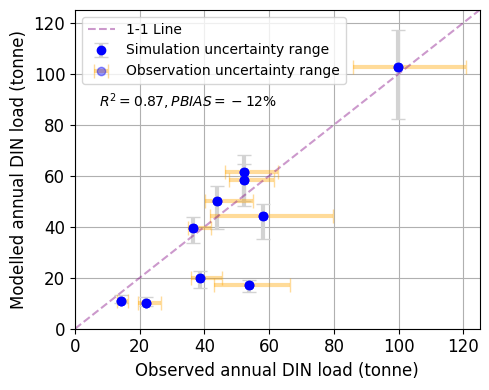

In [55]:
# Create the scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(obs_base, mod_base, color='blue')

# Add error bars to both observations and simulations
plt.errorbar(obs_base, mod_base, yerr=mod_err, fmt='o', color='blue', 
             ecolor='lightgray', elinewidth=3, capsize=5, label='Simulation uncertainty range')
plt.errorbar(obs_base, mod_base, xerr=obs_err, fmt='o', color='blue', 
             ecolor='orange', alpha = 0.4, elinewidth=3, capsize=5, label='Observation uncertainty range')


# Add the 1-1 line
max_value = max(obs_base.max(), mod_base.max())  # Get the maximum value for the axis limits
plt.plot([0, 125], [0, 125], color='purple', alpha=0.4, linestyle='--', label='1-1 Line')

# Add labels and title
plt.xlabel('Observed annual DIN load (tonne)', fontsize = lab_fontsize)
plt.ylabel('Modelled annual DIN load (tonne)', fontsize = lab_fontsize)
plt.tick_params(axis='both', labelsize = lab_fontsize)
plt.xlim(0,125)
plt.ylim(0,125)
plt.legend(fontsize = 10)
plt.text(35, 85, r'$R^2 = %.2f, PBIAS = %.0f\%%$' % (r2, pbias), fontsize=10, color='black', ha='center', va='bottom')

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig(f'{fig_dir}ScatterPlotWith Unctn Range.png', format = 'png', dpi = 300)

## 1-2 Time series with uncertainty ranges


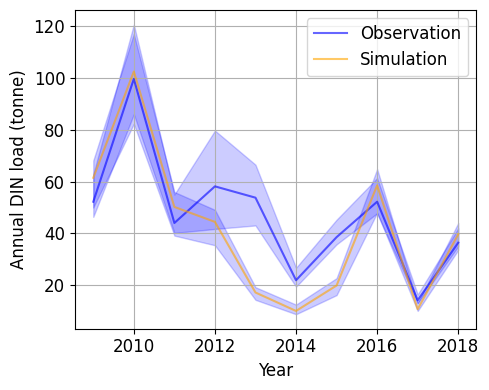

In [18]:
# Plot with uncertainty ranges
plt.figure(figsize=(5, 4))
year_range = np.arange(2009, 2019)
plt.plot(year_range, obs_base, alpha = 0.6, label='Observation', color='blue')
plt.plot(year_range, mod_base, alpha = 0.6, label='Simulation', color='orange')

# Add a shaded area for uncertainty (95PPU)
plt.fill_between(year_range, \
                 (obs_base.values - obs_err.values[0]), \
                 (obs_base.values + obs_err.values[1]), \
                 color='blue', alpha=0.2)
plt.fill_between(year_range, \
                 (mod_base.values - mod_err.values[0]), \
                 (mod_base.values + mod_err.values[1]), \
                 color='blue', alpha=0.2)

# Add labels and title
plt.xlabel('Year', fontsize = lab_fontsize)
plt.ylabel('Annual DIN load (tonne)', fontsize = lab_fontsize)
plt.tick_params(axis='both', labelsize = lab_fontsize)
plt.legend(fontsize = lab_fontsize)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig(f'{fig_dir}TimeseriestWithUnctnRange.png', format = 'png', dpi = 300)

## 2-1 Boxplot of parameter posteriors

In [62]:
# Read RELATIVE parameter values -- relative values that are normalized to its prior ranges
par_fn = 'Sandy_Creek.11.par.csv'
par_df = pd.read_csv(data_dir + par_fn, index_col='real_name')
par_melt = pd.melt(par_df, var_name='Parameter Name', value_name='Parameter Value')
# Read parameters prior and names; The column of ShortName will be used as the x-axis index.
default_pars = pd.read_excel('../data/default_starting_params.xlsx')

# Read ABSOLUTE parameter values -- relative values that are normalized to its prior ranges
abs_par_fn = 'parameter_absolute_value.csv'
abs_par_df = pd.read_csv(data_dir + abs_par_fn, index_col='real_name')
abs_par_melt = pd.melt(abs_par_df, var_name='Parameter Name', value_name='Parameter Value')

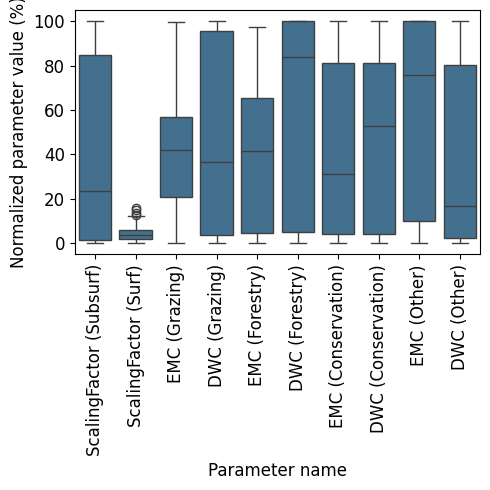

In [56]:
# Boxplot
plt.figure(figsize=(5, 5))
ax = sns.boxplot(data=par_melt, x = 'Parameter Name', y = 'Parameter Value', saturation=0.5)
plt.ylabel('Normalized parameter value (%)', fontsize = lab_fontsize)
plt.xlabel('Parameter name', fontsize = lab_fontsize)
plt.xticks(ticks=np.arange(default_pars.shape[0]), labels=default_pars['ShortName'], rotation = 90);
plt.tick_params(axis='both', labelsize = lab_fontsize)
# Show the plot
plt.tight_layout()
plt.savefig(f'{fig_dir}BoxPlotParameterUncertainty.png', format = 'png', dpi = 300)

## 2-2 Pairwise Plot between parameters: SDR and gEMC

<Figure size 500x800 with 0 Axes>

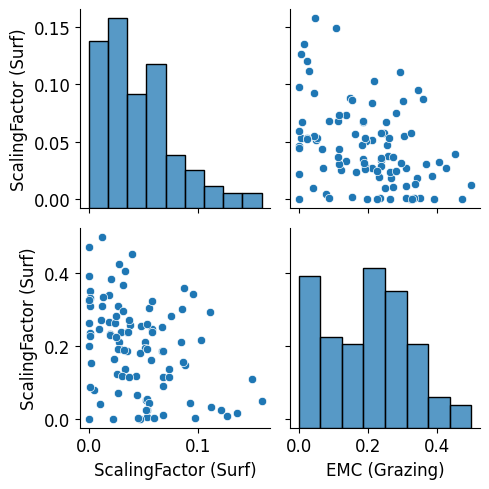

In [78]:
fig = plt.figure(figsize=(5, 8))
pairplot = sns.pairplot(abs_par_df.loc[:, ['scale_din','gemc']])
# Customize x-axis labels for each plot
new_xlabels = [default_pars['ShortName'][1], default_pars['ShortName'][2],\
               default_pars['ShortName'][1], default_pars['ShortName'][2]]
for i, ax in enumerate(pairplot.axes.flatten()):
    # Change x-axis label for each subplot
    ax.set_xlabel(new_xlabels[i], fontsize = lab_fontsize)
    ax.tick_params(labelsize = lab_fontsize)
    # ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, color='black', lw=2, transform=ax.transAxes))
    if i ==0:
        ax.set_ylabel(new_xlabels[i], fontsize = lab_fontsize)
    elif i == 2:
        ax.set_ylabel(new_xlabels[i], fontsize = lab_fontsize)

# Show the plot
plt.tight_layout()
plt.savefig(f'{fig_dir}PairPlotParameters.png', format = 'png', dpi = 300)

In [ ]:
# Annual scale L-Q plot; seasonal scale average concentration?
